# Lab 5: Competitive learning on the MNIST database

## Learning Outcomes
- Understand how competive learning works.
- Ability to develop and tune a simple neural network using competitive learning.

## Lecture Overview

### Competitive learning
- In competitive learning, the output neurons compete among themselves to be activated (fire).
- In contrast with the Hebbian learning, here only one neuron (or group of neurons) can be activate at a time.
- The output neuron that wins the competitionis is often called winner-take-all neuron.

<img src="http://bitsandchips.me/COM3240_Adaptive_Intelligence/Lecture5/icons/fig1.png" width="500">


### Main steps for compatitive learning implementation:
1. Generate a set of output neurons with random weights.
2. Choose a random input pattern and calculate the activation of each of the output neurons.
3. Detect the winner neuron and update only its weights; the weights of the other neurons are not updated:  , where  is the winner neuron,  is the learning rate and  is the input vector.
4. Repeat from step 2 until the weights are no longer changing, or change less than a set threshold, or a set maximum number of iterations has been reached.

### Some optimisation and tuning methods:
1. Normalised input or initial weights.
2. Noise addition on the weights.
3. Decaying learning rate.
4. Leaky learning: update the weights of the losers as well as winners but with a much smaller learning rate.
5. Update the winners and neighbouring losers.

### K-means clustering
Clustering: given a set of datapoints we want to group them based on their similarity. Each one of these groups is called cluster.

In k-means clustering the task is to separate our data into k clusters. However specifying the number of clusters k is a common problem in machine learning and there are various different methods for finding the optimal k.

The k-means algorithm is the following:
<img src="http://bitsandchips.me/COM3240_Adaptive_Intelligence/Lecture5/icons/fig2.png" width="500">

### Competitive learning vs K-means clustering
Essentially they are equivalent.

Competitive learning leads to clusters since each output neuron after training is firing on a certain input (has learn a specific data pattern).
The terms centroid and protorype are equivalent.

## Laboratory 5: Competitive learning on the MNIST database

### Exercise
The aim of this lab is to implement the standard competitive learning algorithm on a one layer network and use it to classify the hand written digits set. You may use the max operator to find the winner for each input. Please choose the number of output units such that you can capture all classes and tune the network such that it will learn quickly and result in as few dead units as possible. One suggestion is to add noise to the decision neurons, in combination with an appropriate decaying learning rate, but you are free to apply other techniques. In this example you are able to visualise both data and prototypes, and can easily locate the dead units. The vectors provided are 28x28 images and you can reshape them to see the digits. Propose a method for detecting dead units, without using the visualisation of the prototypes. Note: It is a good and sometimes necessary practice to normalise the weight vector and the data at the beginning of the process.

You will need to produce the following :
1. A figure showing the average weight change as a function of time. When your network has sufficiently learned from the data? If you implement an on-line version of the rule you may use a moving average to produce a smooth curve of the weight changes through time. Such a curve may be more informative on semi-log or log-log axes.
2. A figure of the prototypes and a comment on what they represent. How many prototypes did your network find?
3. The correlation matrix of the prototypes. How can you use this information to find similarities between the prototypes?

In [230]:
import numpy as np
import numpy.matlib
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the data set

In [231]:
train = np.genfromtxt ('letters.csv', delimiter=",")
trainlabels = np.genfromtxt ('letterslabels.csv', delimiter=",")

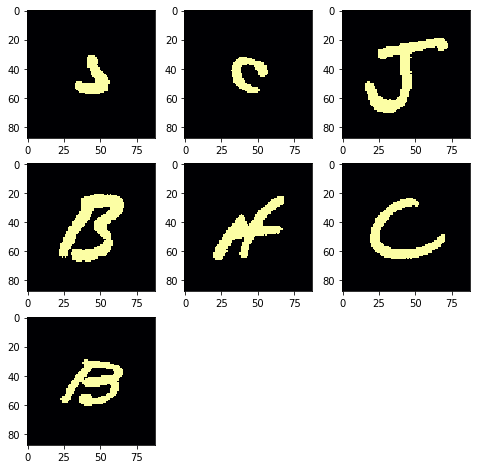

In [232]:
[n,m]  = np.shape(train)                    # number of pixels and number of training data
pix = int(math.sqrt(n))

fig = plt.figure(figsize=(8,8))
columns = 3
rows = 3
for y in range(columns*rows-2):
    fig.add_subplot(rows, columns, y+1)
    image = np.reshape(train[:,y],(pix,pix),order="F")
    plt.imshow(image, cmap = 'inferno');

#### Normalising train data

In [233]:
normT = np.sqrt(np.diag(train.T.dot(train)))

train = train / np.matlib.repmat(normT.T,n,1)
data = train

#### Parameters and variables 

In [369]:
[n,m]  = np.shape(data)                    # number of pixels and number of training data
eta    = 0.05                            # learning rate
winit  = 1                                  # parameter controlling magnitude of initial conditions
alpha = 0.990

tmax   = 5000
letters = 20

W = winit * np.random.rand(letters,n)        # Weight matrix (rows = output neurons, cols = input neurons)
normW = np.sqrt(np.diag(W.dot(W.T)))
normW = normW.reshape(letters,-1)            # reshape normW into a numpy 2d array

W = W / np.matlib.repmat(normW.T,n,1).T    # normalise using repmat
# W = W / normW                               # normalise using numpy broadcasting -  http://docs.scipy.org/doc/numpy-1.10.1/user/basics.broadcasting.html

noise = np.random.rand(letters,n)
noise_boolean = False
W = W + noise
noise_boolean = True

counter = np.zeros((1,letters))              # counter for the winner neurons
wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time


####  Implementation, training and output

In [370]:
for t in range(1,tmax):
    i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
    x = data[:,i]                          # pick a training instance using the random index

    h = W.dot(x)/letters                     # get output firing
    h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array

#     noise = np.random.rand(letters,1)/200   # add noise
#     output = np.max(h+noise)                      # get the max in the output firing vector
    output = np.max(h)
    k = np.argmax(h)                        # get the index of the firing neuron
    h[k] = 0
    k2 = np.argmax(h)
    h[k2] = 0
    k3 = np.argmax(h)
#     h[k3] = 0
#     k4 = np.argmax(h)

    

    counter[0,k] += 1                       # increment counter for winner neuron

    y = counter[0,k]/1000
    
#     dw = (eta * np.exp(-y)) * (x.T - W[k,:])    # get closer to the input (x - W) 
    dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron
    dw2 = eta * (x.T - W[k2,:])                                        
    dw3 = eta * (x.T - W[k3,:])
    
    wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)
    
    
#     W[k,:] = W[k,:] + dw - (dw*0.1)                   
#     W = W + (dw*0.1)
    W[k,:] = W[k,:] + dw                    # weights for k-th output are updated
#     W[k2,:] = W[k2,:] + (dw2*0.1)
#     W[k3,:] = W[k3,:] + (dw3*0.1)
     

####  Number of Dead Cells

In [371]:
print(counter)

dead_cells = 0
for c in counter[0,:]:
    if(not noise_boolean):
        if(c < 50):
            dead_cells += 1
    else:
        if(c < 150):
            dead_cells += 1
print(dead_cells)

[[276. 356. 176. 289. 250. 166. 213. 163. 255. 134. 307. 439. 155. 419.
  192. 331. 238. 198. 201. 241.]]
1


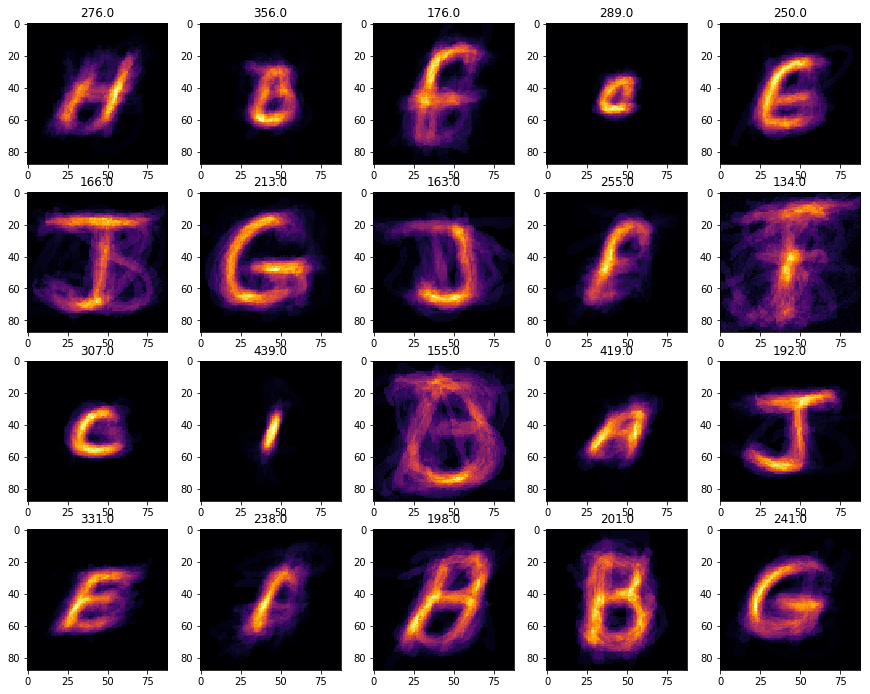

In [372]:
# Plot a prototype
fig = plt.figure(figsize=(15,15))
columns = letters//4
rows = letters//4
for y in range(letters):
    fig.add_subplot(rows, columns, y+1).set_title(counter[0,y])
    plt.imshow(W[y,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')

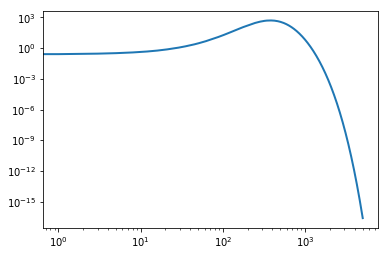

In [373]:
# Plot running average
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(wCount[0,0:tmax], linewidth=2.0, label='rate')

ax.set_yscale('log')
ax.set_xscale('log')